# Modeling Science Education topics over time using Latent Dirichlet Allocation

### Tor Ole B. Odden and Alessandro Marin


## I. Introduction: Topic modeling of Science Education papers
In this notebook, we perform a topic analysis of papers from the journal Science Education (formerly General Science Quarterly), which has been publishing articles since 1916.

To do this, we will be using a technique called Latent Dirichlet Allocation, or LDA. LDA is one of a family of machine learning techniques, within the subfield of natural language processing, that analyze text to pull out topics and essential features. Notably, it's a mixed-membership model, which means that it assumes each document will be a mixture of several different topics (the exact number being specified beforehand). Given certain hyperparameters (such as the number of topics and the expected distributions of topics in the different documents), it then attempts to derive the topics from word co-occurrences.

This notebook guides you through the main aspects of the modeling process. To begin with, we have downloaded all articles from Science Education/General Science Quarterly, starting in 1922 (papers were missing from 1919-1921, and the text of papers prior to 1919 was heavily corrupted).

We scraped the text from these PDFs into a dataframe, and done some basic cleaning on the text: 
* Removing references
* Removing symbols, numbers, and stopwords (such as "and", "is", and "but") 
* Lowercasing all text
* Lemmatizing the text, reducing words to their more basic forms (for example, "testing", "tested", and "tests" to the base word "test")
* Creating bi-grams by uniting words that are commonly used together and which carry a specialized meaning when put together, such as "high_school"
* Turning the text into a series of single words, called "tokens"

In this notebook, we will start by taking our cleaned data and do some filtering, which will improve the quality of our eventual model. This results in the final set of data (a so-called "bag of words") that we use to train the model. We then train a few example models, and compute various measures of quality including coherence, perplexity, and a visual inspection of the most representative papers in each topic. Finally, we use this model to look at the prevalence of topics over time.

### A. Importing Packages

We need a lot of packages for this analysis. The primary packages we use are Gensim, which is a library used to do this kind of LDA topic modeling. We will also import PyLDAvis, a visualiation package for LDA, and our usual data analysis tools (pandas, matplotlib, numpy) and pickle to store our data for later analysis.

In [1]:
# Print out  all expressions
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #default 'last_expr'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>")) 

C:\Users\EfiaA\AppData\Local\Temp\ipykernel_18992\1460559018.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
#Import gensim, our library for text analysis
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora.dictionary import Dictionary
from sklearn.feature_extraction.text import CountVectorizer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# Import usual data analysis tools
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#np.random.seed(2018)

import pickle

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning);

import os

We have also defines some helper scripts for commonly-used functions like paths to pdfs and stored data files.

In [3]:

dir_name_e = r'C:\Users\EfiaA\OneDrive - Imperial College London\Imperial academic work\University life\Y4\MSci project\Project_Coding\nlp-physicseducation\Pickledfiles'
dir_csv3 = 'outputs/labels_cleaned_y1y2.csv'
df = pd.read_csv(dir_csv3, encoding='utf-8')
print(df)

     Unnamed: 0               StudentID  \
0             0  2ndINT_MHH822_Redacted   
1             1  2ndINT_GYI981_Redacted   
2             2  2ndINT_MFR246_Redacted   
3             3  2ndINT_CTW087_Redacted   
4             4  2ndINT_HBQ145_Redacted   
..          ...                     ...   
173         173      GS_LSK572_Redacted   
174         174      GS_YZI659_Redacted   
175         175      GS_CTW087_Redacted   
176         176      GS_MFR246_Redacted   
177         177      GS_KGR276_Redacted   

                                               Content ArgumentLevel  \
0    a michelson interferometer be built and use to...    prediction   
1    in this experiment a series of light spectl 3 ...          deep   
2    in this experiment we explore the spectral com...   superficial   
3    the purpose of this experiment be to calculate...        expert   
4    michelson interferometer with a movable mirror...          deep   
..                                                 

## II. Loading in and filtering the data

The datafile we use for this analysis is a pickle file containing processed versions of Science Education papers from 1922 to 2019. There are 5577 articles in this dataset, after some preliminary filtering to remove advertisements and articles with no author. This processed data was then stored in a datafile, which we now load in:

In [4]:
data_words_bigrams = df['Content']
#pd.read_pickle(path_pkl+'scied_words_bigrams_V5.pkl')
#print(data_words_bigrams)

data_words_bigrams2 = []
for i in range(len(data_words_bigrams)):
    data_words_bigrams2.append([data_words_bigrams.iloc[i]])




### A. Plotting top words in all documents

Now, we will do some investigation and filtering based on word frequency. Our goal is to filter out the words that occur in a large number of documents, which are less likely to carry any distinct meaning for any specific theories, methods, or research traditions in science education. For example, most people in the science education research community talk about "science", "education", and "students" in one form or another. Those words do not carry a very specialized meaning within the subfield, and so should be removed from our dataset in order to make sure that the more interesting, distinct, and meaningful words are prioritized in the analysis.

We start by defining and importing some more helper functions to plot the word frequency distribution in the dataset.

In [5]:
# from helpers import plot_freq_dist,get_top_n_words,plot_words_freq

In [6]:
corpus = [ w for doc in data_words_bigrams2 for w in doc]
print('Total words: \033[1m%d\033[0m, unique words: \033[1m%d\033[0m' % (len(corpus), len(set(corpus))))

# [words, freq, ids] = get_top_n_words(corpus, n_top_words=None)
# fig = plot_freq_dist(freq, range=[0,8000])
# fig, ax = plot_words_freq(words, freq, 15)



Total words: 178, unique words: 177


As we can see, the top words in the dataset include "science", "student", "teacher", "study", "teach", "learn", and "education". Because these words are so overrepresented, they need to be filtered out. This is an essential step, since topic models like LDA are based on word co-occurrences, which means that word that are over-represented in the data can wash out the more interesting trends in our data (i.e., words that are theoretically relevant to particular subgroups or research paradgims within science education). 

### B. Creating a Bag of Words to filter the dataset

Thankfully, Gensim already has a built-in function to do this kind of filtering, "filter_extremes", which allows us to filter out words that appear too many or too few times. The parameters are:
* **no_below**: an integer. Keep tokens which are contained in at least no_below documents.  
* **no_above**: a float number between 0 and 1. It filters out tokens which are contained in more than no_above percentage of documents. E.g. with no_above=0.5, tokens in in more than 50% of the documents get cut out.  
* **keep_n**: an integer. It specifies how many tokens should be kept, starting with the most frequent.

However, to use this function we must first create a [Gensim Dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary), which is a mapping between each of the entries (i.e. normalized words) and its integer id in the corpus. 

Based on repeated runs with different filtering values, we've set the no_above parameter to 0.50, which filters out 133 words (displayed below). We set our no_below value to 15; this is somewhat arbitrary, but considering the size of the dataset (5577 documents) any words that appear in less than 15 documents are probably not worth keeping—oftentimes they are scanning errors, typos, or names.

After the filtering we convert the remaining tokens into a "bag of words" (BoW). We also display the resulting distribution for the most common words after filtering.

In [7]:
no_below = 1
no_above = 0.5
import copy
id2word_unfiltered_above = gensim.corpora.Dictionary(data_words_bigrams2) #Needed for a bug
id2word_unfiltered_above.filter_extremes(no_below=no_below, no_above=1, keep_n=10000)
#id2word_unfiltered_above.filter_extremes(no_below=no_below, no_above=1, keep_n=100000)
print("Dictionary with \033[1mno_above=1\033[0m contains \033[1m%d\033[0m unique words\n" % (len(id2word_unfiltered_above)))

id2word = gensim.corpora.Dictionary(data_words_bigrams2)
#id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000)

#Effect of using no_above
diff_set = set(list(id2word_unfiltered_above.values())) - set(list(id2word.values()))
print("Dictionary filtered with \033[1mno_above=%.2f\033[0m contains \033[1m%d\033[0m unique words. \033[1m%d words\033[0m removed:\n %s \n" % 
      (no_above, len(id2word), len(diff_set), sorted(diff_set)))

Dictionary with no_above=1 contains 177 unique words

Dictionary filtered with no_above=0.50 contains 177 unique words. 0 words removed:
 [] 



In [8]:
# from tools import ml_tools
# no_below = 1
# no_above = 5

# id2word_unfiltered_above = gensim.corpora.Dictionary(data_words_bigrams2) #Needed for a bug
# print("Unfiltered Dictionary contains \033[1m%d\033[0m unique words" % len(id2word_unfiltered_above)) #209780

# id2word = gensim.corpora.Dictionary(data_words_bigrams2)
# id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000)
# #print(id2word)

# #Create BoW
# bow_corpus = ml_tools.BoW(df['Content'].tolist())
# #bow_corpus = [id2word.doc2bow(doc) for doc in data_words_bigrams2]
# print(bow_corpus)
# #Get most frequent words from id2word Dictionary
# #There is a bug with csf: https://github.com/RaRe-Technologies/gensim/issues/2574
# [ids, freq] = zip(*sorted(id2word.cfs.items(), key=lambda x: x[1], reverse=True))
# words = [id2word_unfiltered_above[id] for id in ids]  #have to use id2word_unfiltered to retrieve words from ids!!
# # Plot distribution
# #plt.hist(freq, range=[0,200])
# #plt.plot(words, freq, 20)

In [7]:
print(df)

     Unnamed: 0               StudentID  \
0             0  2ndINT_MHH822_Redacted   
1             1  2ndINT_GYI981_Redacted   
2             2  2ndINT_MFR246_Redacted   
3             3  2ndINT_CTW087_Redacted   
4             4  2ndINT_HBQ145_Redacted   
..          ...                     ...   
173         173      GS_LSK572_Redacted   
174         174      GS_YZI659_Redacted   
175         175      GS_CTW087_Redacted   
176         176      GS_MFR246_Redacted   
177         177      GS_KGR276_Redacted   

                                               Content ArgumentLevel  \
0    a michelson interferometer be built and use to...    prediction   
1    in this experiment a series of light spectl 3 ...          deep   
2    in this experiment we explore the spectral com...   superficial   
3    the purpose of this experiment be to calculate...        expert   
4    michelson interferometer with a movable mirror...          deep   
..                                                 

In [9]:
# import 
# importing tool functions
import numpy as np
import matplotlib.pyplot as plt
from tools import utils, ml_tools
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
!python -m spacy download en_core_web_sm
import spacy

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora



# remove stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))


def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = df['Content'].tolist()
data_words_send = list(sent_to_words(data))


# remove stop words
data_words_nostopwords = remove_stopwords(data_words_send)
# print(data_words_nostopwords[:1][0][:30])

# functions
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words_nostopwords, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words_nostopwords], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostopwords)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:1][0][:30])

#create 

id2word = corpora.Dictionary(data_lemmatized)

#create corpus
texts = data_lemmatized

#Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

#View 
print(len(corpus))

  Using cached en_core_web_sm-2.3.1-py3-none-any.whl
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\EfiaA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

178


## III. Running LDA using Bag of Words

### A. Explanation of LDA

Now, the good part, the topic modeling. To do the modeling, we are using a technique known as Latent Dirichlet Allocation, or LDA. LDA assumes the following generative process for documents: for each document, pick a particular topic according to a certain distribution. Within each topic, pick words based on a particular distribution. The algorithm tries to determine (estimate, fit) these distributions through a stochastic sampling process, based on the co-occurrence of words in the document. It ends up with two things that it estimates: a distribution of topics within each document, and a distribution of words within each topic. In practice, these end up being matrices: one is a document-topic matrix, which has rows corresponding to documents and columns corresponding to the amount of each topic the model predicts is present in each document (dimensions Num_docs x Num_topics). The other is a topic-term matrix, where each row is a topic and each column is a single word from the corpus (dimensions Num_topics x Num_words). Thus, this technique can also be thought of as a kind of probabilistic matrix factorization (see [Hoffman](https://www.researchgate.net/publication/221618332_Online_Learning_for_Latent_Dirichlet_Allocation) for more on this).

The particular distributions depend on parameters that are fed to the model: $\alpha$ tells the model whether is should expect a small number of topics per document (small $\alpha$), vs a larger number in a more even mixture (large $\alpha$). Similarly, $\beta$ is a parameter that controls whether topics have a few central words, or a larger number of more evenly distributed words. Both are based on the [Dirichlet distribution](https://towardsdatascience.com/dirichlet-distribution-a82ab942a879), which essentially is a function that allows you to specify a distribution across a probability simplex (a kind of generalized shape with several “corners”) where the parameter you feed it specifies how likely points are to fall into a specific corner vs. be distributed evenly across the shape. Note, however, that in both of these matrices, each row is a probability distribution across different discrete outcomes (choice of topics or choice of words) and so each row will add up to 1. And, their values will vary considerably. For example, in the topic-word matrix if you had a corpus of 4000 words and every word was equally likely to be chosen for a particular topic, the values in the that row of the (topics x words) matrix would all be 1/4000 = .00025 = 2.5e-4. However, in practice, for particular topics a large number of words will be rated very low, on the order of 1e-6 or 1e-7, while certain other words will be rated highly, on the order of 1e-2 or even higher. It is therefore common when presenting topics to pick the 5-10 most likely words for a particular topic

### B. Training our LDA model

We call the LdaModel function (which does the actual LDA modeling). We pass the following arguments:  
* bow_corpus - our data corpus, in a "bag of words" format  
* num_topics - the number of topics we intend the algorithm to identify. We set this to 10.  
* id2word - the dictionary that maps words to IDs  
* passes - the number of passes the algorithm should take through the data while training
* iterations - the number of iterations the algorithm will use to try to make the results converge

In addition, we pass three other arguments that are particular to the specific model that we are trying to replicate:
* random_state - a random seed value that determines the initialization of the model, which will affect the specific topics it eventually settles on
* alpha - a parameter that determines how mixed the topics are in each document. Gensim has a built-in fuction that can learn alpha values from the corpus as it runs the model, and we'll use this function here.

The output here is a set of topics, each of which contains a set of words with their corresponding weights.

In [9]:
#Load the "best" model to skip the following cell
#lda_model = pd.read_pickle(path_pkl+'SciEd_NoRefs_RepLDAModel.pkl')

In [15]:
num_topics = 4
#alphatot = 12.5
lda_model = gensim.models.LdaModel(corpus=corpus, 
                                   id2word=id2word, 
                                   num_topics=num_topics,
                                   alpha='auto',
                                   random_state=29, #29 current best, as of 5/6/2020
                                   iterations=15, passes=50)



In [16]:
lda_model.show_topics(num_words=10, num_topics = num_topics)

[(0,
  '0.025*"value" + 0.024*"line" + 0.021*"wavelength" + 0.020*"constant" + 0.020*"error" + 0.017*"light" + 0.015*"grate" + 0.013*"energy" + 0.012*"order" + 0.011*"calculate"'),
 (1,
  '0.029*"run" + 0.014*"emission" + 0.014*"datum" + 0.006*"first" + 0.006*"clearly" + 0.005*"seem" + 0.005*"experiment" + 0.005*"second" + 0.004*"record" + 0.004*"uncertainty"'),
 (2,
  '0.026*"source" + 0.026*"light" + 0.016*"figure" + 0.016*"wavelength" + 0.014*"interference" + 0.012*"lead" + 0.012*"show" + 0.009*"point" + 0.009*"experiment" + 0.008*"would"'),
 (3,
  '0.028*"light" + 0.028*"source" + 0.027*"wavelength" + 0.017*"lead" + 0.015*"point" + 0.011*"white" + 0.010*"find" + 0.010*"fringe" + 0.010*"tungsten" + 0.010*"peak"')]

Save LDAmodel

In [12]:
with open(dir_name_e+'SciEd_NoRefs_RepLDAModel.pkl', 'wb') as output: pickle.dump(lda_model, output)

As one can see, the output of the LDA model is a set of "topics" (we specified the exact number with the num_topics parameter) each of which is composed of words with specific weights. For the purposes of illustration, we have sorted these topics by their most weighted words: For example, Topic 0 includes the words "tutorial, ta, lecture, section, force, and semester" (more words are visible if we increase the num_words parameter in the show_topics method). It's helpful here to remember that from a statistical perspective, each of these topics is essentially a distribution over all of the words in the data corpus, which tells us how likely one would be to draw a particular word, given a particular topic, in the generative process for documents that LDA assumes (described above).

One can get the entire distribution using the "get_topics()" method. For example, here is the vector for topic 8, along with the lowest and highest values.

In [17]:
print("Distribution vector for topic 3: ", lda_model.get_topics()[2], "\n")

print("Maximum value: {} corresponding to the word: {}".format(np.amax(lda_model.get_topics()[2]), id2word[np.argmax(lda_model.get_topics()[2])]))
print("Minimum value: {} corresponding to the word: {}".format(np.amin(lda_model.get_topics()[2]), id2word[np.argmin(lda_model.get_topics()[2])]))

Distribution vector for topic 3:  [1.4539083e-04 4.7287333e-04 1.3071892e-03 ... 1.8459497e-05 1.8460616e-05
 1.8460622e-05] 

Maximum value: 0.026456940919160843 corresponding to the word: source
Minimum value: 1.8451835785526782e-05 corresponding to the word: heated


The maximum value was around 0.015, which corresponds to the word "social". The lowest value is 7.96e-8, corresponding to the word "ab". Thus, in the "draw a topic/draw a word" process described above, one would be 1,880,000 times more likely to draw the word social than to draw the word ab.

One can also start to associate specific themes with each set of topics. For example, Topic 0 focuses on gender and the STEM pipeline; Topic 1 focuses on textbooks; Topic 2 focuses on observation and experiments; and Topic 3 focuses on discourse analysis and identity.

### C. Evaluating models with perplexity and coherence scores
We can evaluate the "goodness" of our topic models using two measures, perplexity and coherence score. Perplexity is essentially a statistical measure of the log probability of unseen test documents fitting into the model (based on the geometric mean of the per-word likelihood). It’s useful for selecting a model but not so useful for topic evaluation since it has been shown to be uncorrelated with human interpretability (Newman et al., 2010). For this reason, coherence is more often used. Coherence measures the degree of semantic similarity between high scoring words in the topic—in other words, are these words roughly being used the same, based on the other words they appear with? These measurements help distinguish between topics that are semantically interpretable ("hang together") and topics that are artifacts of the statistical process LDA uses (Röder, Both, and Hinneburg, 2015).

For the purposes of illustration, we compute both the perplexity and the coherence on the topics we've found. Perplexity is a score in the range from -14 to 14, with lower perplexity being better. Coherence ranges from 0-1, with higher scores being better. We have typically found coherence scores between 0.4-0.53, which stackexchange informs us is okay but not great. We suspect this is because our data is relatively homogeneous—that is, all documents are on variations of topics related to science education, so it's hard to get extremely distinct topics. If, instead, we were analyzing a mixture of documents about 3 distinct subjects (say, sports, religion, and technology companies) we might expect more distinct topics with less overlap and a higher overall coherence.

In [18]:
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts= data_words_send, dictionary=id2word, coherence='c_v')
#Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better
print('\nComplexity: ', coherence_model_lda.get_coherence())


Perplexity:  -6.343104040595362

Complexity:  nan


c:\Users\EfiaA\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
c:\Users\EfiaA\Anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


Of these two measures, both we and the literature (e.g., Röder, Both, and Hinneburg, 2015) have found coherence to be more useful for predicting interpretable topics so we have used it in making decisions about our model. As one can see, this particular model is on the high end of our observed coherence score range (0.522). 

## IV. Results of the model: Visualization, representative papers, and prevalence of topics over time

### A. Visualizing the model

With this model trained, we can use it to explore a variety of different aspects of the resulting topics and their relation to the literature. First, we can use the pyLDAvis package to visualize the topics and see how distinct they are from one another in a 2D space created by principle component analysis on the word space. By mousing over the resulting visual, you can see the different topics, their prevalence (indicated by the size of the circles), the most salient terms in each, and their rough inter-topic "distance."

In [19]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, n_jobs=1) 
pyLDAvis.display(vis)

Sometimes it's possible to see a structure in this 2D space, but it's hard to tell if there's anything here. This may be because this is a 2D slice of an inherently higher-dimensional space, and so this slice may not encompass all that much of the variance in that space. However, we can use this to check if there are any outlying topics that seem to be skewing our model—these will show up as major outliers in the plot. No such outliers are visible here, so that's a good sign.

### B. Explaining the PCA variance of pyLDAvis

One interesting question (relevant if we are to take these interpretations seriously) is how much of the variance is encapsulated by the principle component analysis (PCA) used in pyLDAvis. Although there isn't a direct way to make the function output this number, by looking over the [pyLDAvis pcoa documentation](https://pyldavis.readthedocs.io/en/latest/_modules/pyLDAvis/_prepare.html#js_PCoA) and another [script referenced in that documentation](https://github.com/biocore/scikit-bio/blob/0.5.0/skbio/stats/ordination/_principal_coordinate_analysis.py) we've been able to re-create the functions used for the PCA.

In [20]:
from scipy.stats import entropy
from scipy.spatial.distance import pdist, squareform

def jensen_shannon(P, Q):
    M = 0.5 * (P + Q)
    return 0.5 * (entropy(P, M) + entropy(Q, M))

def pcoa(pair_dists, n_components=2):
    """Principal Coordinate Analysis,
    aka Classical Multidimensional Scaling
    """
    # code referenced from skbio.stats.ordination.pcoa
    # https://github.com/biocore/scikit-bio/blob/0.5.0/skbio/stats/ordination/_principal_coordinate_analysis.py

    # pairwise distance matrix is assumed symmetric
    pair_dists = np.asarray(pair_dists, np.float64)

    # perform SVD on double centred distance matrix
    n = pair_dists.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    B = - H.dot(pair_dists ** 2).dot(H) / 2
    eigvals, eigvecs = np.linalg.eig(B)

    # Take first n_components of eigenvalues and eigenvectors
    # sorted in decreasing order
    ix = eigvals.argsort()[::-1]
    eigvals = eigvals[ix]
    eigvecs = eigvecs[:, ix]

    # replace any remaining negative eigenvalues and associated eigenvectors with zeroes
    # at least 1 eigenvalue must be zero
    eigvals[np.isclose(eigvals, 0)] = 0
    if np.any(eigvals < 0):
        ix_neg = eigvals < 0
        eigvals[ix_neg] = np.zeros(eigvals[ix_neg].shape)
        eigvecs[:, ix_neg] = np.zeros(eigvecs[:, ix_neg].shape)
        
    proportion_explained = eigvals / eigvals.sum()

    return np.sqrt(eigvals) * eigvecs, proportion_explained

def js_PCoA(distributions):
    """Dimension reduction via Jensen-Shannon Divergence & Principal Coordinate Analysis
    (aka Classical Multidimensional Scaling)

    Parameters
    ----------
    distributions : array-like, shape (`n_dists`, `k`)
        Matrix of distributions probabilities.

    Returns
    -------
    pcoa : array, shape (`n_dists`, 2)
    """
    dist_matrix = squareform(pdist(distributions, metric=jensen_shannon))
    return pcoa(dist_matrix)

In [22]:
jspcoa, explained = js_PCoA(lda_model.get_topics()) #run PCoA on the normalized topic vectors
print('Variance explained by PC1: {0:.2f} percent'.format(explained[0]*100))
print('Variance explained by PC2: {0:.2f} percent'.format(explained[1]*100))
print('Total variance explained: {0:.2f} percent'.format((explained[0]+explained[1])*100))

Variance explained by PC1: 72.03 percent
Variance explained by PC2: 24.37 percent
Total variance explained: 96.40 percent


### C. Dominant topic in each document

We can also use this model to make an estimation of the document-topic distribution; that is, for a particular document, find out how much the model associates it with each topic.

In [23]:
def get_weight_in_doc(ldamodel, corpus, doc_num, fill=0):
    """ Get the weigth for each topic in a document
    Inputs: ldamodel, corpus, doc_num, fill (value when topic was not found)
    Output: list of tuples [(<topic number>, <topic weight>)]
    """
    num_topics = ldamodel.num_topics
    weights = [fill] * num_topics
    # Get a list of tuples with the detected topics and weights
    row = ldamodel[corpus][doc_num]
    # Process the output to return a list of weights
    tw = list(zip(*row))
    for topic in range(num_topics):
        if topic in tw[0]:
            ind = tw[0].index(topic)
            weights[topic] = tw[1][ind]
    return weights

def get_weight_per_doc(ldamodel, corpus):
    """ Get a document by topic weight Dataframe 
    Inputs: ldamodel, corpus
    """
    num_topics = ldamodel.num_topics
    dataframe = pd.DataFrame(np.zeros((len(corpus),num_topics)), columns=list(range(num_topics)))
    dataframe.index.name = 'Topic weights'
    for i, row in dataframe.iterrows():
        dataframe.iloc[i] = pd.Series(get_weight_in_doc(ldamodel, corpus, i))
    return dataframe

weights = get_weight_per_doc(lda_model, corpus)

Now, we can associate each weight with its respective document, and see how the  model classifies them:

In [27]:
# Load the DataFrame with processed text
df = pd.read_pickle(dir_name_e+'texts_norefs_clean.pkl')

# Concatenate the topic weights
df = df.loc[:, ['Content','ReasoningLevel','ArgumentLevel']] #drop all columns except the date
df = pd.concat([df, weights], axis = 1) #append the weights

#Display examples
pd.set_option('display.max_columns', None)
df.round(decimals=2)
LDA_results_df = utils.save_as_pickle_file(df,'LDA_results_each_document_topic_weighting',dir_name_e)

,Content,ReasoningLevel,ArgumentLevel,0,1,2,3
0,a michelson interferometer be built and use to...,the,prediction,0.02,0.0,0.05,0.93
1,in this experiment a series of light spectl fr...,bal,deep,0.01,0.0,0.02,0.97
2,in this experiment we explore the spectral com...,bal,superficial,0.00,0.0,0.55,0.44
3,the purpose of this experiment be to calculate...,bal,expert,0.04,0.0,0.63,0.33
4,michelson interferometer with a movable mirror...,none,deep,0.00,0.0,0.02,0.98
...,...,...,...,...,...,...,...
173,the rydberg constant be calculate by use a gra...,bal,deep,0.95,0.0,0.00,0.05
174,the same set up be use a that in figure before...,the,superficial,1.00,0.0,0.00,0.00
175,the purpose of this report be to display the r...,bal,superficial,1.00,0.0,0.00,0.00
176,spectroscopy be commonly use a a non invasive ...,exp,deep,0.95,0.0,0.03,0.02


In [28]:
load_LDA_results_df = utils.load_pickle_file_to_df('LDA_results_each_document_topic_weighting', dir_name_e)
print(load_LDA_results_df)

                                               Content ReasoningLevel  \
0    a michelson interferometer be built and use to...            the   
1    in this experiment a series of light spectl fr...            bal   
2    in this experiment we explore the spectral com...            bal   
3    the purpose of this experiment be to calculate...            bal   
4    michelson interferometer with a movable mirror...           none   
..                                                 ...            ...   
173  the rydberg constant be calculate by use a gra...            bal   
174  the same set up be use a that in figure before...            the   
175  the purpose of this report be to display the r...            bal   
176  spectroscopy be commonly use a a non invasive ...            exp   
177  the rydberg constant allows one to predict how...            bal   

    ArgumentLevel         0    1         2         3  
0      prediction  0.023274  0.0  0.051345  0.925362  
1            

This analysis, for example, associates the 2020 paper "The effect of first high school science teacher's gender and gender matching on students' science identity in college" primarily with Topic 0, (words: achievement, stem, variable, girl, model, mathematics, gender, female, grade, woman, career). This makes sense, since topic 0 seems to be about gender and the STEM pipeline, and this paper fits well with that topic.

We can also search for individual authors. For example, here's the classification for all papers authored by Rudolph, JL since 1995:

In [32]:
name = 'Rudolph'
date = 1995

df[df['StudentID'].str.contains(name) & (df['ArgumentLevel'] > date)].round(decimals=2)

KeyError: 'authors'

There's a definite tendency towards topic 8 (which seems to be about STS/science education policy), topic 9 (history and philosophy of science), and a smaller association with topic 22 (argumentation).

Using this set of weights, we can make a plot of the topic weight (in a percent) by document number. Although this plot is quite messy, the dots above 0.5 on the y-axis show that there are lots of documents that fall more than 50% into a particular topic, and the color shifts show definite rise and fall of different topics over time.

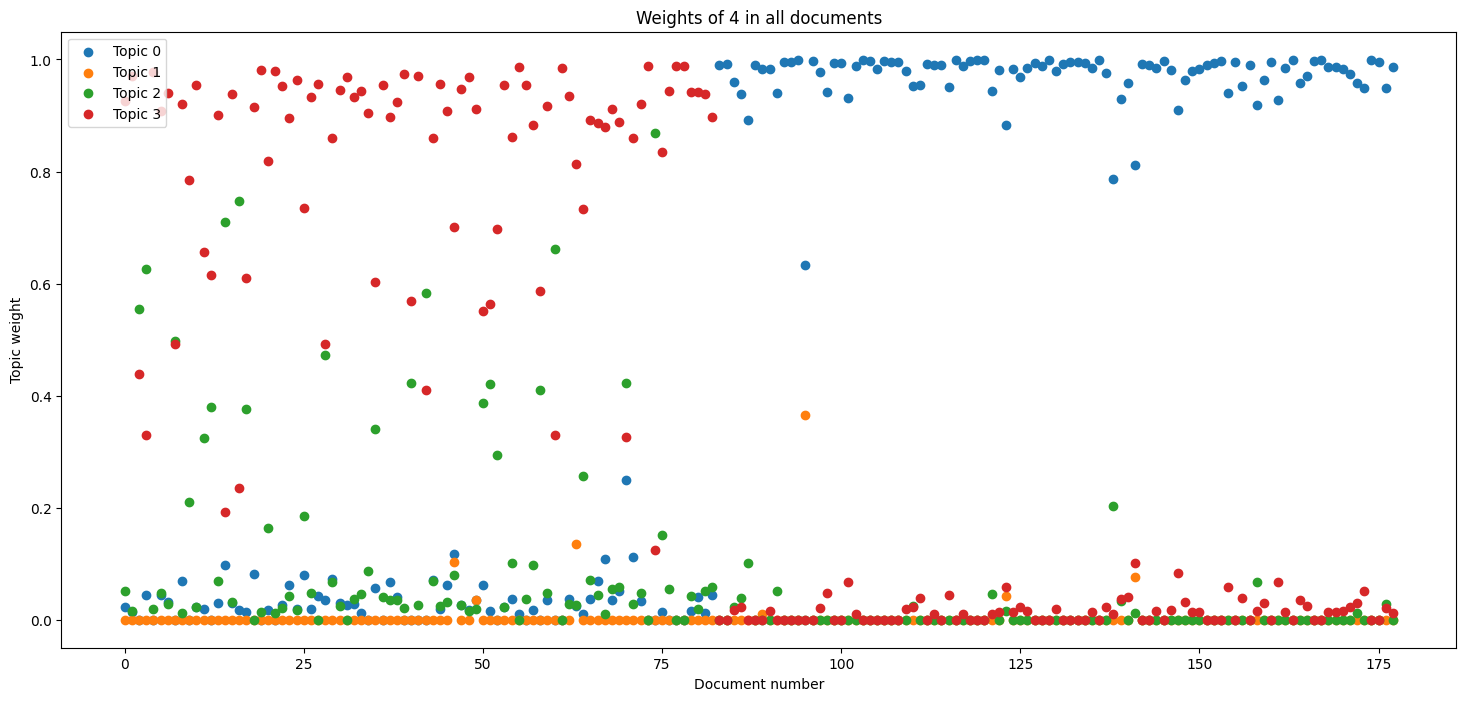

In [29]:
plt.figure(figsize=(18, 8))
for t in range(num_topics):
    plt.scatter(weights.index, weights.iloc[:,t], label='Topic '+str(t))
plt.xlabel("Document number")
plt.ylabel("Topic weight")
plt.legend(loc='upper left')
plt.title('Weights of %d in all documents' % num_topics)
plt.show();

### D. Most representative documents for each topic

We can also go through, topic-by-topic, and find the most representative documents for each topic, which can be useful both for verifying that these topic groupings make sense and to characterize each topic:

In [30]:
num_docs = 10
try:
    #Show tables in plotly if plotly is intalled
    import plotly.graph_objects as go
    for t in range(num_topics):
        #print("Topic {}: {}".format(t,lda_model.print_topics(num_words=6)[t][1]))
        formattedlist = [word[0] for word in lda_model.show_topics(num_topics = 4, formatted=False)[t][1]]
        content = df.sort_values(by=t, ascending=False)[['Content','ReasoningLevel','ArgumentLevel',t]][:num_docs]
        fig = go.Figure(data=[ go.Table(
            #columnwidth = [60, 40, 40, 300, 220],
            columnwidth = [ 300, 40, 40],
            header=dict(
                #values=['<b>Document number</b>', '<b>Weight</b>', '<b>Year</b>', '<b>Title</b>', '<b>Authors</b>'],
                values = ['<b>Document Identification</b>', '<b>Epistemology</b>', '<b> Argument Level </b>'],
                height=48,
                font_size=14,
                line_color='black',
                fill_color='lightgrey'),
            cells=dict(
                #values=[list(content.index), list(round(content[t],2)), list(content.Content), list(content.ReasoningLevel), list(content.ArgumentLevel)],
                values = [list(content.Content), list(content.ReasoningLevel), list(content.ArgumentLevel)],
                align=['center', 'center', 'center', 'left', 'left'],
                height=48,
                font_size=12,
                line_color='black',
                fill_color='white')) ])
        fig.update_layout( title_text="Topic {}: {}".format(t,formattedlist) )
        #fig.show() 
    del content
except: 
    pd.set_option('display.max_colwidth', 150)
    for t in range(num_topics):
        print("Topic {}: {}".format(t,lda_model.print_topics(num_words=6)[t][1]))
        df.sort_values(by=t, ascending=False)[['StudentID','ReasoningLevel','ArgumentLevel',t]][:num_docs]
        # sort in terms of studentID then Reasoning level and then Argument levell
        print('\n\n')

### E. Time plot of topic weights

Finally, we can plot the "prevalence" of each topic as a function of time. That is, for each year we can add up the percentage of each topic in each document from that year's Science Education articles (normalized by the number of documents) and plot that as a function of time. Intuitively, we can think of this "prevalence" as being a measure of the percentage of papers published on that topic in that year, found by adding up the fractional topic contributions from each paper each year.

It can, however, be tricky to see overall trends with so much year-to-year variation. So, in the next plots we have implemented a smoothing function in the form of a average across a 3-year rolling window. This effectively serves to dampen out small variations, while leaving larger trends intact. However, it also neglects the first and last years.

Note that when you run this notebook (if you have plotly) these figures are interactive, so you can display or remove plots from the graph by clicking on the legend.

In [31]:
# Prevalence for argument level
import plotly
import plotly.express as px

#plotlydata = df.groupby('year').agg('mean').rolling(3, min_periods=3, win_type='triang').mean().dropna()
plotlydata = df.groupby('ArgumentLevel').agg('mean').rolling(3, min_periods=3, win_type='triang').mean().dropna()
#plotlydata = df.groupby('ArgumentLevel')
#plotlydata['Years'] = plotlydata.index.values
plotlydata['ArgumentLevel'] = plotlydata.index.values
print(  plotlydata.index.values)
#plotlydata = plotlydata[plotlydata['Years']<2020]
#plotlydata = plotlydata[plotlydata['ArgumentLevel']]

#tidy_df = plotlydata.melt(id_vars="Years", var_name = "Topic", value_name = "Prevalence (percent)") 
tidy_df = plotlydata.melt(id_vars="ArgumentLevel", var_name = "Topic", value_name = "Prevalence (percent)") 
tidy_df['words'] = ''
for t in range(num_topics):
    formattedlist = [topic[0] for topic in lda_model.show_topics(num_topics = 3, formatted=False, num_words = 5)[t][1]]
    print('Topic {}:'.format(t), ', '.join(formattedlist))
    tidy_df.loc[tidy_df['Topic'] == t, 'words'] = ', '.join(formattedlist)

# fig = px.line(tidy_df, x="Years", y="Prevalence (percent)", color='Topic', line_dash = "Topic", 
#               hover_data = ['words'], title = 'Average Topic Prevalence over Time', width=1200, height=800)
# fig.show()

fig = px.line(tidy_df, x="ArgumentLevel", y="Prevalence (percent)", color='Topic', line_dash = "Topic", 
              hover_data = ['words'], title = 'Average Topic Prevalence over ArgumentLevel', width=1200, height=800)
fig.show()


['extended' 'prediction' 'superficial']
Topic 0: run, emission, datum, first, clearly
Topic 1: light, source, wavelength, lead, point
Topic 2: value, line, wavelength, constant, error


IndexError: list index out of range

In [34]:
# Prevelance for Epistemology

#plotlydata = df.groupby('year').agg('mean').rolling(3, min_periods=3, win_type='triang').mean().dropna()
plotlydata = df.groupby('ReasoningLevel').agg('mean').rolling(3, min_periods=3, win_type='triang').mean().dropna()
#plotlydata['Years'] = plotlydata.index.values
plotlydata['ReasoningLevel'] = plotlydata.index.values
#plotlydata = plotlydata[plotlydata['Years']<2020]
#plotlydata = plotlydata[plotlydata['ArgumentLevel']]

#tidy_df = plotlydata.melt(id_vars="Years", var_name = "Topic", value_name = "Prevalence (percent)") 
tidy_df = plotlydata.melt(id_vars="ReasoningLevel", var_name = "Topic", value_name = "Prevalence (percent)") 
tidy_df['words'] = ''
for t in range(num_topics):
    formattedlist = [topic[0] for topic in lda_model.show_topics(num_topics = 25, formatted=False, num_words = 5)[t][1]]
    print('Topic {}:'.format(t), ', '.join(formattedlist))
    tidy_df.loc[tidy_df['Topic'] == t, 'words'] = ', '.join(formattedlist)

# fig = px.line(tidy_df, x="Years", y="Prevalence (percent)", color='Topic', line_dash = "Topic", 
#               hover_data = ['words'], title = 'Average Topic Prevalence over Time', width=1200, height=800)
# fig.show()

fig = px.line(tidy_df, x="ReasoningLevel", y="Prevalence (percent)", color='Topic', line_dash = "Topic", 
              hover_data = ['words'], title = 'Average Topic Prevalence over Epistemology(Reasoning Level)', width=1600, height=800)
fig.show()

Topic 0: value, line, wavelength, constant, error
Topic 1: run, emission, datum, first, clearly
Topic 2: source, light, figure, wavelength, interference
Topic 3: light, source, wavelength, lead, point


Here, we can see that there are definite trends over time. For example, there's an early focus on topic 18, which seems to be about "natural philosophy. Prior to 1970 theres a big focus on topic 20, which seems to be about 

Another way to look at this is by just adding up the fractional contributions of papers, without averaging. This means that the graph will be more sentitive to year-to-year variations in numbers of articles published, but that provides some interesting information too. Here, the y-axis can be interpreted as a measure of the total number of papers published a topic each year.

##### Efia - this could be useful for the analysis of year 1 and year 2 documents separately.

In [80]:
# plotlydata = df.groupby('year').agg('sum').rolling(3, min_periods=3, win_type='triang').mean().dropna()
# plotlydata['Years'] = plotlydata.index.values
# plotlydata = plotlydata[plotlydata['Years']<2020]

# tidy_df = plotlydata.melt(id_vars="Years", var_name = "Topic", value_name = "Cumulative Documents") 

# tidy_df['words'] = ''
# for t in range(num_topics):
#     formattedlist = [topic[0] for topic in lda_model.show_topics(num_topics = 25, formatted=False, num_words = 5)[t][1]]
#     print('Topic {}:'.format(t), ', '.join(formattedlist))
#     tidy_df.loc[tidy_df['Topic'] == t, 'words'] = ', '.join(formattedlist)

# fig = px.line(tidy_df, x="Years", y="Cumulative Documents", color='Topic', line_dash = 'Topic', 
#               hover_data = ['words'],title = 'Cumulative Topic Prevalence over Time', width=1200, height=800)
# fig.show()

KeyError: 'year'

Although the plot is somewhat crowded, there are...

## V. Conclusions

In conclusion, we are able to see some interesting trends over time here. We are still working on understanding where these trends might come from. More to come on this soon!

# References

1. Hoffman, M. D., Blei, D. M. & Bach, F. Online Learning for Latent Dirichlet Allocation (Supplementary Material). Nature 0, 1–9 (2010).
2. Newman, D., Lau, J. H., Grieser, K. & Baldwin, T. Automatic evaluation of topic coherence. in NAACL HLT 2010 - Human Language Technologies: The 2010 Annual Conference of the North American Chapter of the Association for Computational Linguistics, Proceedings of the Main Conference 100–108 (2010).
3. Röder, M., Both, A. & Hinneburg, A. Exploring the space of topic coherence measures. WSDM 2015 - Proc. 8th ACM Int. Conf. Web Search Data Min. 399–408 (2015). doi:10.1145/2684822.2685324